In [1]:
from QuantLib import *
import QuantLib as ql
import pandas as pd

# from IPython.core.interactiveshell import InteractiveShell
# InteractiveShell.ast_node_interactivity = "all"

import sys, os
cwd = os.getcwd()
sys.path.append(cwd)

In [2]:
from modules.bond import *
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import dates
sns.set_style("darkgrid")

from modules.curve import YieldCurve

### Set Parameters

In [3]:
# today = datetime.strptime("2019-08-19", "%Y-%m-%d")
today = datetime.strptime("2019-08-20", "%Y-%m-%d")

In [4]:
xl = pd.ExcelFile('Portfolio.xlsx')
sheet_names = [name for name in xl.sheet_names if name not in ['Portfolio']]
print(sheet_names)           

['TO21', 'AY24', 'AA25', 'A2E2', 'A2E7', 'AO20', 'PARP', 'CO26', 'CUAP']


In [5]:
dfs = []
for sheet_name in sheet_names:
    new_df = pd.read_excel(open('Portfolio.xlsx', 'rb'), sheet_name=sheet_name)[['Fecha de Pago', 'Cash Flow']]
    new_df['Bond'] = sheet_name
    new_df['Cash Flow'] = new_df['Cash Flow'].apply(lambda cf: cf.replace(',','.'))
    new_df['Cash Flow'] = pd.to_numeric(new_df['Cash Flow'])
    
    new_df['Price'] = -new_df.iloc[0]['Cash Flow']
    new_df['Price Date'] = new_df.iloc[0]['Fecha de Pago']
    new_df = new_df.drop(0)
    new_df['Fecha de Pago'] = pd.to_datetime(new_df['Fecha de Pago'], format="%d/%m/%Y")
    dfs.append(new_df)
df = pd.concat(dfs, 0)
df['Fecha de Pago'] = pd.to_datetime(df['Fecha de Pago'], format="%d/%m/%Y")
df['Price Date'] = today

In [6]:
df.head()

,Fecha de Pago,Cash Flow,Bond,Price,Price Date
1,2019-10-03,9.1,TO21,70.0,2019-08-20
2,2020-04-03,9.1,TO21,70.0,2019-08-20
3,2020-10-03,9.1,TO21,70.0,2019-08-20
4,2021-04-03,9.1,TO21,70.0,2019-08-20
5,2021-10-03,109.1,TO21,70.0,2019-08-20


In [8]:
# df.Bond.unique()
df = df[df.Bond.isin(['TO21'])]

### Generate CASHFLOWS FOR EACH BOND

In [9]:
instruments = [BondGenerator.bond_from_dataframe(df[df.Bond==name]) for name in df.Bond.unique().tolist()]
ytm_curve = YieldCurve(today, instruments)

[-70.0, 9.1, 9.1, 9.1, 9.1, 109.1]
[-70.0, 9.099890307515556, 9.09943410068634, 9.098977916728241, 9.098524248261514, 109.07683854856835]
[-70.0, 8.827636718955349, 7.779598428135754, 6.855985767186669, 6.0462007834285805, 63.8820215444059]
[-70.0, 8.726772892533731, 7.331777887447843, 6.159776088232995, 5.180049485536616, 52.17625364505676]
[-70.0, 8.662728473507219, 7.058387752660502, 5.751171564394788, 4.691299880758525, 45.8276264126677]
[-70.0, 8.646615679853342, 6.990917080682824, 5.652260195032957, 4.575247347634876, 44.349214389965226]
[-70.0, 8.644691610289287, 6.98289511171316, 5.640551027077739, 4.561568279594598, 44.175711391784155]
[-70.0, 8.644641751180567, 6.9826873342227955, 5.640247891227737, 4.561214312722718, 44.17122386786127]
[-70.0, 8.64464161129384, 6.982686751280899, 5.6402470407580285, 4.561213319654754, 44.17121127808805]


In [10]:
instruments = [BondGenerator.bond_from_dataframe(df[df.Bond==name]) for name in df.Bond.unique().tolist()]
ytm_curve = YieldCurve(today, instruments)

In [11]:
# YTM ORIGINAL
z = pd.DataFrame(data={ 
    'maturity': ytm_curve.maturities, 
    'yield': ytm_curve.yields, 
    'name': ytm_curve.names,
    'period': ytm_curve.periods
}).sort_values(by='maturity', ascending=True)
z['Curves'] = 'YTM'
z.T

,5,0,3,1,2,7,4,6,8
maturity,2020-10-08 00:00:00,2021-10-03 00:00:00,2022-01-26 00:00:00,2024-05-07 00:00:00,2025-04-18 00:00:00,2026-10-27 00:00:00,2027-01-26 00:00:00,2038-12-31 00:00:00,2045-12-31 00:00:00
name,AO20,TO21,A2E2,AY24,AA25,CO26,A2E7,PARP,CUAP
period,1.13699,2.12329,2.43836,4.71781,5.66575,7.19178,7.4411,19.3781,26.3836
yield,0.499351,0.530884,0.365363,0.413056,0.286952,0.081828,0.199663,0.100111,0.106204
Curves,YTM,YTM,YTM,YTM,YTM,YTM,YTM,YTM,YTM


### Extensiones

In [8]:
# # YTM INTERPOLATED
# maturities, yields = ytm_curve.interpolated_in_intervals(40)
# z_interpolated = pd.DataFrame(data={'maturity': maturities, 'yield': yields}).sort_values(by='maturity', ascending=True)
# z_interpolated['Curves'] = 'interpolated YTM'

# # SPOT CURVE
# spot_curve = ytm_curve.implied_spot_curve(n_points=20)
# spot_curve_maturities, spot_curve_yields = spot_curve.maturities, spot_curve.yields
# z_spot = pd.DataFrame(data={'maturity': spot_curve_maturities, 'yield': spot_curve_yields}).sort_values(by='maturity', ascending=True)
# z_spot['Curves'] = 'SPOT'

In [9]:
# SPOT CURVE (SPECIFIC DATES)
spot_dates = ['2020-10-8', '2021-10-3', '2022-1-26', '2023-1-1', '2024-5-7', '2025-4-18', '2026-10-27', '2027-1-26', '2038-12-31', '2045-12-31']
specific_dates = sorted([datetime.strptime(x, "%Y-%m-%d") for x in spot_dates])

spot_curve_2 = ytm_curve.implied_spot_curve(specific_dates=specific_dates)
spot_curve_maturities_2, spot_curve_yields_2 = spot_curve_2.maturities, spot_curve_2.yields

z_spot_2 = pd.DataFrame(data={'maturity': spot_curve_maturities_2, 'yield': spot_curve_yields_2}).sort_values(by='maturity', ascending=True)
z_spot_2['Curves'] = 'SPOT'

#######
tot =  0
n_days =  415
period =  1.1369863013698631
yield_interpolated =  0.4993514269027107
value =  0.42794096237071577
#######
# sum:  0.5308836184570183
tot =  0.3540755082040323
n_days =  775
period =  2.1232876712328768
yield_interpolated =  0.5308836184570183
value =  0.5014126494284228
#######
# sum:  0.3653629258062832
# sum:  0.3653629258062832
tot =  0.39783793194698674
n_days =  890
period =  2.4383561643835616
yield_interpolated =  0.3653629258062832
value =  0.3989725062305165
#######
# sum:  0.384852982655726
# sum:  0.384852982655726
# sum:  0.384852982655726
tot =  0.5887909471955064
n_days =  1230
period =  3.3698630136986303
yield_interpolated =  0.384852982655726
value =  0.4337960215512038
#######
# sum:  0.41305624139080194
# sum:  0.41305624139080194
# sum:  0.41305624139080194
# sum:  0.41305624139080194
tot =  0.7545896115973709
n_days =  1722
period =  4.717808219178083
yield_interpolated =  0.41305624139080194
value =  0.4492664644851445
#######
# sum

In [13]:
z.T

,5,0,3,1,2,7,4,6,8
maturity,2020-10-08 00:00:00,2021-10-03 00:00:00,2022-01-26 00:00:00,2024-05-07 00:00:00,2025-04-18 00:00:00,2026-10-27 00:00:00,2027-01-26 00:00:00,2038-12-31 00:00:00,2045-12-31 00:00:00
name,AO20,TO21,A2E2,AY24,AA25,CO26,A2E7,PARP,CUAP
period,1.13699,2.12329,2.43836,4.71781,5.66575,7.19178,7.4411,19.3781,26.3836
yield,0.499351,0.530884,0.365363,0.413056,0.286952,0.081828,0.199663,0.100111,0.106204
Curves,YTM,YTM,YTM,YTM,YTM,YTM,YTM,YTM,YTM


In [14]:
z_spot_2.T

,0,1,2,3,4,5,6,7,8,9
maturity,2020-10-08 00:00:00,2021-10-03 00:00:00,2022-01-26 00:00:00,2023-01-01 00:00:00,2024-05-07 00:00:00,2025-04-18 00:00:00,2026-10-27 00:00:00,2027-01-26 00:00:00,2038-12-31 00:00:00,2045-12-31 00:00:00
yield,0.427941,0.501413,0.398973,0.433796,0.449266,0.215503,0.0411968,0.164966,0.0267514,0.0250985
Curves,SPOT,SPOT,SPOT,SPOT,SPOT,SPOT,SPOT,SPOT,SPOT,SPOT


In [11]:
forward_curve = spot_curve_2.get_forward_curve()
forward_maturities, forward_rates = forward_curve.maturities, forward_curve.yields
z_forward = pd.DataFrame(data={'maturity': forward_maturities, 'yield': forward_rates}).sort_values(by='maturity', ascending=True)
z_forward['Curves'] = 'FORWARD'
z_forward.T

#######
T1: 2019-08-20 00:00:00
T2: 2021-01-01 00:00:00
R1: 0
R2: 0.3489003452664896
Days:  500
Diff:  1.36986301369863
1.032518356442488
#######
T1: 2021-01-01 00:00:00
T2: 2021-10-01 00:00:00
R1: 0.3489003452664896
R2: 0.5008655241385365
Days:  273
Diff:  0.7479452054794521
0.5074950889794865
#######
T1: 2021-10-01 00:00:00
T2: 2023-01-01 00:00:00
R1: 0.5008655241385365
R2: 0.2935458980291934
Days:  457
Diff:  1.252054794520548
0.18958931325825756
#######
T1: 2023-01-01 00:00:00
T2: 2024-01-01 00:00:00
R1: 0.2935458980291934
R2: 0.342163250594713
Days:  365
Diff:  1.0
0.3926078649327611
#######
T1: 2024-01-01 00:00:00
T2: 2025-01-01 00:00:00
R1: 0.342163250594713
R2: 0.2392932242034007
Days:  366
Diff:  1.0027397260273974
0.14498046885286797
#######
T1: 2025-01-01 00:00:00
T2: 2028-01-01 00:00:00
R1: 0.2392932242034007
R2: 0.08603947222575092
Days:  1095
Diff:  3.0
0.12255690306144618
#######
T1: 2028-01-01 00:00:00
T2: 2035-01-01 00:00:00
R1: 0.08603947222575092
R2: 0.03651521292994

,0,1,2,3,4,5,6
maturity,2021-01-01 00:00:00,2021-10-01 00:00:00,2023-01-01 00:00:00,2024-01-01 00:00:00,2025-01-01 00:00:00,2028-01-01 00:00:00,2035-01-01 00:00:00
yield,1.03252,0.507495,0.189589,0.392608,0.14498,0.122557,0.227002
Curves,FORWARD,FORWARD,FORWARD,FORWARD,FORWARD,FORWARD,FORWARD


In [12]:
z_spot_2.T

,0,1,2,3,4,5,6
maturity,2021-01-01 00:00:00,2021-10-01 00:00:00,2023-01-01 00:00:00,2024-01-01 00:00:00,2025-01-01 00:00:00,2028-01-01 00:00:00,2035-01-01 00:00:00
yield,0.3489,0.500866,0.293546,0.342163,0.239293,0.0860395,0.0365152
Curves,SPOT,SPOT,SPOT,SPOT,SPOT,SPOT,SPOT


In [17]:
z.T

,5,0,3,1,2,7,4,6,8
maturity,2020-10-08 00:00:00,2021-10-03 00:00:00,2022-01-26 00:00:00,2024-05-07 00:00:00,2025-04-18 00:00:00,2026-10-27 00:00:00,2027-01-26 00:00:00,2038-12-31 00:00:00,2045-12-31 00:00:00
name,AO20,TO21,A2E2,AY24,AA25,CO26,A2E7,PARP,CUAP
yield,0.499351,0.530884,0.365363,0.413056,0.286952,0.081828,0.199663,0.100111,0.106204
Curves,YTM,YTM,YTM,YTM,YTM,YTM,YTM,YTM,YTM


In [13]:
# Days differences
diff = [(x[1]-x[0]).days for x in list(zip(z_spot_2.maturity.tolist(), z_spot_2.maturity.tolist()[1:]))]
diff

[273, 457, 365, 366, 1095, 2557]

In [16]:
# (1+s2)2 = (1+s1) (1+1f1)
#######
#######
# T1: 2019-08-20 00:00:00
# T2: 2021-01-01 00:00:00
# R1: 0
# R2: 0.3489003452664896
# Days:  500
# Diff:  1.36986301369863
# 1.032518356442488

print((1+0.3489)*(1+1.03252))
print((1+0.500866)**(273/365.))


2.7416662279999997
1.3548589767215145


### Curva YTM

/home/pedro/.local/lib/python3.5/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'FORWARD vs. YTM')

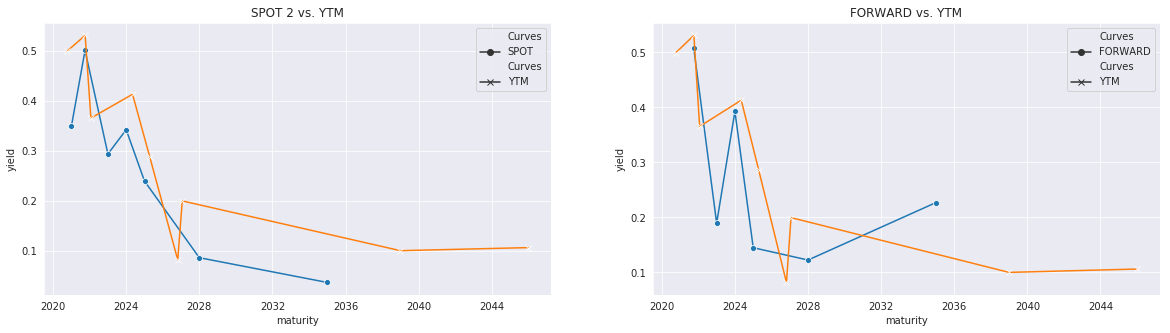

In [18]:
# Plots
fig, ax = plt.subplots(figsize=(20,5), ncols=2, nrows=1)

# SPOT 2 VS YTM
sns.lineplot(data=z_spot_2, x='maturity', y='yield', ax=ax[0], markers=["o"], style="Curves")
sns.lineplot(data=z, x='maturity', y='yield', ax=ax[0], markers=["x"], style="Curves")
ax[0].set_title('SPOT 2 vs. YTM')

# FORWARD vs. YTM
sns.lineplot(data=z_forward, x='maturity', y='yield', ax=ax[1], markers=["o"], style="Curves")
sns.lineplot(data=z, x='maturity', y='yield', ax=ax[1], markers=["x"], style="Curves")
ax[1].set_title('FORWARD vs. YTM')

In [14]:
# spot_curve_2.maturities
# map_maturity_yield = {}
# for i,_ in enumerate(maturities):
#     self.map_maturity_yield[maturities[i]] = yields[i]

In [15]:
# [(x - spot_curve_2.today).days / 365. for x in spot_curve_2.maturities]
z_spot_2.T

,0,1,2,3,4,5,6
maturity,2021-01-01 00:00:00,2021-10-01 00:00:00,2023-01-01 00:00:00,2024-01-01 00:00:00,2025-01-01 00:00:00,2028-01-01 00:00:00,2035-01-01 00:00:00
yield,0.3489,0.500866,0.293546,0.342163,0.239293,0.0860395,0.0365152
Curves,SPOT,SPOT,SPOT,SPOT,SPOT,SPOT,SPOT


In [16]:
# spot_curve_2.yields
z_forward.T

,0,1,2,3,4,5
maturity,2021-10-01 00:00:00,2023-01-01 00:00:00,2024-01-01 00:00:00,2025-01-01 00:00:00,2028-01-01 00:00:00,2035-01-01 00:00:00
yield,-0.281511,-0.302137,-0.254934,-0.193739,-0.400476,-0.412302
Curves,FORWARD,FORWARD,FORWARD,FORWARD,FORWARD,FORWARD


In [20]:
# (1+0.34)*(1+0.77)
# 1F1 (one year forward, 1 year from now): (1+s2)**2/(1+s1) – 1
def calculate_forward_rate(T1, T2, R1, R2):
#     return (R2*T2 - R1*T1)/(T2 - T1)
    return (1+R2)**(1+T2-T1)/(1+R1) - 1

print(calculate_forward_rate(3,4,0.06,0.065))
print(calculate_forward_rate(3,4,0.34,0.5))

0.07002358490566007
0.6791044776119401


In [24]:
# (forward_curve.maturities[1] - forward_curve.maturities[0]).days / 365.
(1+0.5)**(1+1.25)/(1+0.34) - 1

0.8582345666609879

In [18]:
forward_rates = []
periods = forward_curve.maturities
for i, T in enumerate(zip(periods, periods[1:])):
    T2, T1 = T
    R1 = forward_curve.map_maturity_yield[T1]
    R2 = forward_curve.map_maturity_yield[T2]
    diff = (T2 - T1).days / 365.

    forward_rate = (1+R2)**(1+diff)/(1+R1) - 1
    forward_rates.append(forward_rate)
forward_rates

AttributeError: 'ForwardCurve' object has no attribute 'map_maturity_yield'

### Curva Spot

Text(0.5, 1.0, 'SPOT vs. YTM')

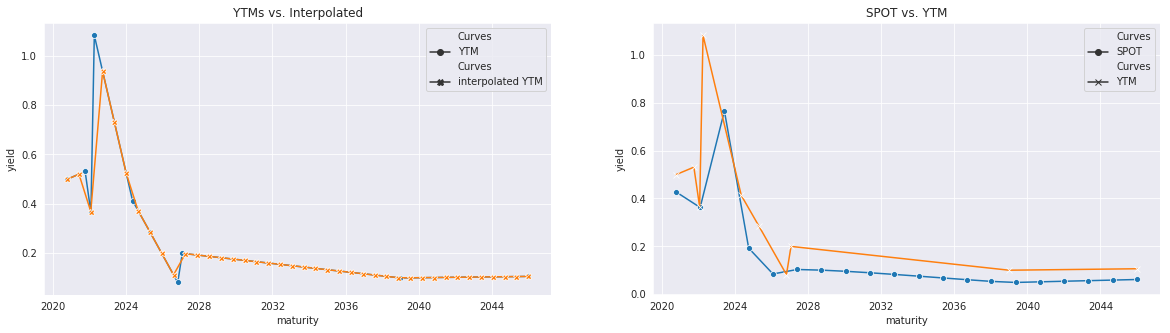

In [16]:
# Plots
fig, ax = plt.subplots(figsize=(20,5), ncols=2, nrows=1)

# BOTh
sns.lineplot(data=z, x='maturity', y='yield', ax=ax[0], markers=["o"], style="Curves")
sns.lineplot(data=z_interpolated, x='maturity', y='yield', ax=ax[0], markers=["X"], style="Curves")
ax[0].set_title('YTMs vs. Interpolated')

# SPOT vs. YTM
sns.lineplot(data=z_spot, x='maturity', y='yield', ax=ax[1], markers=["o"], style="Curves")
sns.lineplot(data=z, x='maturity', y='yield', ax=ax[1], markers=["x"], style="Curves")
ax[1].set_title('SPOT vs. YTM')
